## 誤差逆伝播法に対応した２層ニューラルネットワーク

In [79]:
import sys, os
import numpy as np
from collections import OrderedDict
import math

sys.path.append("../deep-learning-from-scratch-master")
from dataset.mnist import load_mnist

### 関数の定義

In [80]:
# ソフトマックス関数
def softmax(x):
    """ミニバッチに対しても適用できるsoftmax関数"""
    x = x - np.max(x, axis=-1, keepdims=True)  # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


# 交差エントロピー誤差
def cross_entropy_error(y, t):
    """予測値yと正解ラベルtの交差エントロピー誤差を返す。１次元のベクトルに対しても、行列（ミニバッチ）に対しても適用可。"""

    # バッチがない場合（yが１次元のベクトルの場合）も、1×n 行列に変換しておく
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換する
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### 各レイヤーの定義

In [81]:
# バッチ対応Affineレイヤー
class Affine:

    def __init__(self, W: np.ndarray, b: np.ndarray):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x: np.ndarray):
        self.x = x
        return np.dot(x, self.W) + self.b

    def backward(self, dout: np.ndarray):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        # dBはY1からYnまでの偏微分の和
        self.db = np.sum(dout, axis=0)
        return dx


# バッチ対応ReLUレイヤー
class ReLU:

    def __init__(self):
        self.mask = None

    def forward(self, x: np.ndarray):
        self.mask = x <= 0  # 行列の要素が0以下の場所を記録
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout: np.ndarray):
        dout[self.mask] = 0
        return dout


# バッチ対応Softmax-with-Lossレイヤー
class SoftmaxWithLoss:

    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x: np.ndarray, t: np.ndarray):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]  # type: ignore
        # バッチサイズで割り、データ１個あたりの誤差が伝播するようにしている
        dx = (self.y - self.t) / batch_size  # type: ignore
        return dx

### ２層ネットワークの定義

In [82]:
class TwoLayerNet:

    def __init__(
        self,
        inputSize: int,
        hiddenSize: int,
        outputSize: int,
        weightInitStd: float = 0.01,
    ) -> None:

        # 重みの初期化（W1, W2は標準偏差がweightInitStdの正規分布で初期化する）
        self.params = {}
        self.params["W1"] = weightInitStd * np.random.randn(inputSize, hiddenSize)
        self.params["b1"] = np.zeros(hiddenSize)
        self.params["W2"] = weightInitStd * np.random.randn(hiddenSize, outputSize)
        self.params["b2"] = np.zeros(outputSize)

        # レイヤーの生成
        self.layers = OrderedDict()  # 順番付きディクショナリを使用
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu1"] = ReLU()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x: np.ndarray):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x: np.ndarray, t: np.ndarray):
        y = self.predict(x)
        # Softmax-with-Errorレイヤーで、教師ラベルとの交差エントロピー誤差を求める
        return self.lastLayer.forward(y, t)

    def accuracy(self, x: np.ndarray, t: np.ndarray):
        y = self.predict(x)
        y = np.argmax(y, axis=1)  # バッチに含まれる画像１枚ごとの、推測されたラベル

        if t.ndim != 1:  # 教師ラベルtがone-hot形式の場合は、ただの数字に変換する
            t = np.argmax(t, axis=1)

        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x: np.ndarray, t: np.ndarray):

        # 入力データをもとに推論し、交差エントロピー誤差を求める
        self.loss(x, t)

        # 逆伝播によってそれぞれの重み・バイアスの勾配を求める
        dout = self.lastLayer.backward(1)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 各レイヤーに記録された勾配の情報を記録する
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db

        return grads

### 誤差伝播法を使った学習

In [83]:
# MNISTデータの読み込み
(xTrain, tTrain), (xTest, tTest) = load_mnist(normalize=True, one_hot_label=True)

# ネットワークの初期化
hiddenSize = 50
network = TwoLayerNet(inputSize=784, hiddenSize=hiddenSize, outputSize=10)

itersNum = 10000
trainSize = xTrain.shape[0]
batchSize = 100
learningRate = 0.1

trainLossList = []
trainAccuracyList = []
testAccuracyList = []

iterPerEpoch = max(trainSize / batchSize, 1)

print("  EPOCH  | TRAIN_ACC | TEST_ACC ")
print("---------|-----------|-----------")

# 学習を行う
for i in range(itersNum):

    # ランダムにバッチデータを選ぶ
    batchMask = np.random.choice(trainSize, batchSize)
    xBatch = xTrain[batchMask]
    tBatch = tTrain[batchMask]

    # 誤差逆伝播法によって勾配を求める
    grad = network.gradient(xBatch, tBatch)

    # 重みを更新する
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learningRate * grad[key]

    # バッチデータに対する損失関数を計算して記録する
    trainLossList.append(network.loss(xBatch, tBatch))

    # １エポックごとに、訓練データとテストデータに対する認識精度を記録する
    if i % iterPerEpoch == 0:
        trainAccuracy = network.accuracy(xTrain, tTrain)
        trainAccuracyList.append(trainAccuracy)
        testAccuracy = network.accuracy(xTest, tTest)
        testAccuracyList.append(testAccuracy)

        # 結果を表示する
        print(
            f'{"{: >3}".format(int(i / iterPerEpoch))} /{"{: >3}".format(math.floor(itersNum / iterPerEpoch))} | {trainAccuracy*100:7.3f}%  | {testAccuracy*100:7.3f}%'
        )

  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |  11.762%  |  11.920%
  1 / 16 |  90.408%  |  90.630%
  2 / 16 |  92.320%  |  92.260%
  3 / 16 |  93.625%  |  93.540%
  4 / 16 |  94.678%  |  94.470%
  5 / 16 |  95.255%  |  95.140%
  6 / 16 |  95.615%  |  95.390%
  7 / 16 |  96.123%  |  95.880%
  8 / 16 |  96.448%  |  95.980%
  9 / 16 |  96.612%  |  96.290%
 10 / 16 |  96.873%  |  96.440%
 11 / 16 |  97.195%  |  96.550%
 12 / 16 |  97.343%  |  96.580%
 13 / 16 |  97.550%  |  96.910%
 14 / 16 |  97.505%  |  96.880%
 15 / 16 |  97.670%  |  96.850%
 16 / 16 |  97.918%  |  97.000%


### 学習済みのパラメータを表示してみる

W1.shape: (784, 50)


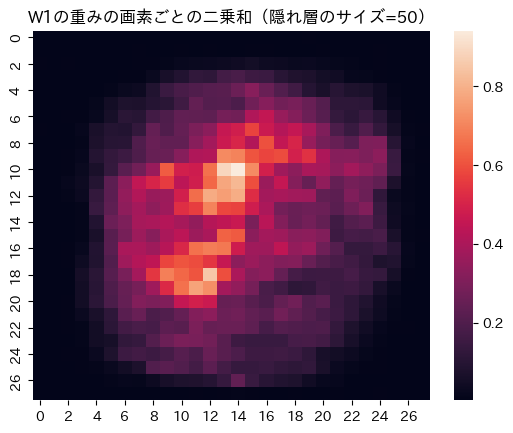

In [84]:
# １層目のW
W1 = network.params['W1'].copy()
print(f"W1.shape: {W1.shape}")

# Wを画素ごとに二乗和をとる
W1 = np.sum(W1**2, axis=1)
W1 = W1.reshape(28,28)

# プロットする
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.figure()
sns.heatmap(W1, annot=False)
plt.title(f'W1の重みの画素ごとの二乗和（隠れ層のサイズ={hiddenSize}）')
plt.show()

### 隠れ層のサイズを変えてみる

**n=1**
```
  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |   9.035%  |   8.920%
  1 / 16 |  27.807%  |  27.830%
  2 / 16 |  28.647%  |  29.090%
  3 / 16 |  29.543%  |  29.990%
  4 / 16 |  28.637%  |  29.460%
  5 / 16 |  30.312%  |  30.710%
  6 / 16 |  33.597%  |  32.420%
  7 / 16 |  37.112%  |  37.070%
  8 / 16 |  37.275%  |  36.910%
  9 / 16 |  36.647%  |  36.270%
 10 / 16 |  36.487%  |  36.230%
 11 / 16 |  36.500%  |  36.180%
 12 / 16 |  36.448%  |  36.260%
 13 / 16 |  38.138%  |  36.680%
 14 / 16 |  38.392%  |  37.560%
 15 / 16 |  37.762%  |  37.050%
 16 / 16 |  38.650%  |  37.720%
```

**n=2**
```
  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |   9.223%  |   8.980%
  1 / 16 |  47.967%  |  49.040%
  2 / 16 |  54.183%  |  54.300%
  3 / 16 |  54.657%  |  54.710%
  4 / 16 |  55.342%  |  55.420%
  5 / 16 |  57.597%  |  57.190%
  6 / 16 |  61.607%  |  61.710%
  7 / 16 |  64.347%  |  64.710%
  8 / 16 |  66.410%  |  66.650%
  9 / 16 |  67.432%  |  67.790%
 10 / 16 |  68.673%  |  68.730%
 11 / 16 |  68.990%  |  69.050%
 12 / 16 |  68.293%  |  68.540%
 13 / 16 |  68.117%  |  68.210%
 14 / 16 |  68.155%  |  67.560%
 15 / 16 |  68.500%  |  68.140%
 16 / 16 |  68.687%  |  68.600%
```

**n=3**
```
  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |  11.675%  |  11.150%
  1 / 16 |  73.305%  |  74.030%
  2 / 16 |  75.515%  |  75.790%
  3 / 16 |  76.492%  |  77.090%
  4 / 16 |  77.375%  |  77.740%
  5 / 16 |  76.322%  |  76.700%
  6 / 16 |  77.328%  |  77.570%
  7 / 16 |  78.393%  |  78.210%
  8 / 16 |  78.357%  |  78.320%
  9 / 16 |  78.843%  |  78.920%
 10 / 16 |  77.727%  |  77.760%
 11 / 16 |  79.420%  |  79.800%
 12 / 16 |  79.023%  |  78.990%
 13 / 16 |  79.543%  |  79.290%
 14 / 16 |  79.055%  |  78.810%
 15 / 16 |  79.813%  |  79.940%
 16 / 16 |  79.788%  |  79.720%
```

**n=4**
```
  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |   9.015%  |   8.870%
  1 / 16 |  80.730%  |  80.710%
  2 / 16 |  83.377%  |  83.890%
  3 / 16 |  84.493%  |  84.630%
  4 / 16 |  85.317%  |  85.200%
  5 / 16 |  85.647%  |  85.680%
  6 / 16 |  86.048%  |  85.880%
  7 / 16 |  86.325%  |  85.930%
  8 / 16 |  86.642%  |  86.510%
  9 / 16 |  86.257%  |  86.030%
 10 / 16 |  86.470%  |  86.290%
 11 / 16 |  86.405%  |  86.060%
 12 / 16 |  87.118%  |  86.690%
 13 / 16 |  86.597%  |  86.220%
 14 / 16 |  86.635%  |  86.450%
 15 / 16 |  86.848%  |  86.360%
 16 / 16 |  87.265%  |  87.010%
```

**n=5**
```
  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |   8.318%  |   8.230%
  1 / 16 |  85.025%  |  85.380%
  2 / 16 |  87.253%  |  87.320%
  3 / 16 |  88.178%  |  87.900%
  4 / 16 |  88.840%  |  88.350%
  5 / 16 |  89.147%  |  88.930%
  6 / 16 |  89.525%  |  89.030%
  7 / 16 |  88.902%  |  88.620%
  8 / 16 |  89.537%  |  89.350%
  9 / 16 |  89.713%  |  89.580%
 10 / 16 |  89.863%  |  89.370%
 11 / 16 |  89.555%  |  88.720%
 12 / 16 |  89.472%  |  89.270%
 13 / 16 |  90.067%  |  89.340%
 14 / 16 |  90.338%  |  89.720%
 15 / 16 |  90.362%  |  89.470%
 16 / 16 |  90.155%  |  89.330%
```

**n=10**
```
  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |  11.315%  |  11.610%
  1 / 16 |  88.780%  |  89.180%
  2 / 16 |  90.293%  |  90.600%
  3 / 16 |  91.000%  |  91.160%
  4 / 16 |  91.598%  |  91.680%
  5 / 16 |  92.192%  |  92.040%
  6 / 16 |  92.815%  |  92.510%
  7 / 16 |  92.958%  |  92.950%
  8 / 16 |  93.355%  |  93.010%
  9 / 16 |  93.650%  |  93.210%
 10 / 16 |  93.697%  |  93.210%
 11 / 16 |  93.982%  |  93.350%
 12 / 16 |  93.820%  |  93.160%
 13 / 16 |  93.698%  |  93.100%
 14 / 16 |  94.163%  |  93.500%
 15 / 16 |  94.140%  |  93.560%
 16 / 16 |  94.263%  |  93.550%
```

**n=25**
```
  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |  14.020%  |  14.400%
  1 / 16 |  89.733%  |  89.750%
  2 / 16 |  91.730%  |  92.090%
  3 / 16 |  92.902%  |  93.170%
  4 / 16 |  93.702%  |  93.850%
  5 / 16 |  94.128%  |  93.870%
  6 / 16 |  94.888%  |  94.590%
  7 / 16 |  95.153%  |  94.670%
  8 / 16 |  95.213%  |  94.850%
  9 / 16 |  95.848%  |  95.480%
 10 / 16 |  96.023%  |  95.530%
 11 / 16 |  96.278%  |  95.770%
 12 / 16 |  96.147%  |  95.510%
 13 / 16 |  96.498%  |  95.720%
 14 / 16 |  96.552%  |  95.840%
 15 / 16 |  96.808%  |  96.100%
 16 / 16 |  96.847%  |  96.040%
```
**n=50**
```
  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |   8.620%  |   8.880%
  1 / 16 |  90.363%  |  90.730%
  2 / 16 |  92.305%  |  92.610%
  3 / 16 |  93.642%  |  93.550%
  4 / 16 |  94.462%  |  94.220%
  5 / 16 |  95.025%  |  94.960%
  6 / 16 |  95.540%  |  95.410%
  7 / 16 |  95.923%  |  95.760%
  8 / 16 |  96.247%  |  95.810%
  9 / 16 |  96.618%  |  96.080%
 10 / 16 |  96.812%  |  96.250%
 11 / 16 |  97.052%  |  96.490%
 12 / 16 |  97.130%  |  96.430%
 13 / 16 |  97.423%  |  96.770%
 14 / 16 |  97.535%  |  96.760%
 15 / 16 |  97.622%  |  96.890%
 16 / 16 |  97.808%  |  97.010%
```

**n=75**

```
  EPOCH  | TRAIN_ACC | TEST_ACC 
---------|-----------|-----------
  0 / 16 |  21.135%  |  21.370%
  1 / 16 |  90.472%  |  90.980%
  2 / 16 |  92.507%  |  92.710%
  3 / 16 |  93.967%  |  93.860%
  4 / 16 |  94.825%  |  94.590%
  5 / 16 |  95.303%  |  94.900%
  6 / 16 |  95.935%  |  95.560%
  7 / 16 |  96.487%  |  95.920%
  8 / 16 |  96.875%  |  96.360%
  9 / 16 |  97.155%  |  96.490%
 10 / 16 |  97.415%  |  96.650%
 11 / 16 |  97.612%  |  96.960%
 12 / 16 |  97.787%  |  97.080%
 13 / 16 |  97.932%  |  97.110%
 14 / 16 |  97.937%  |  97.010%
 15 / 16 |  98.197%  |  97.250%
 16 / 16 |  98.273%  |  97.380%
```

In [ ]:
# 誤差逆伝播（1000回分の速度を計測）

for i in range(1000):  # 1000回分の計算時間を測定する
    net = TwoLayerNet(inputSize=784, hiddenSize=50,
                      outputSize=10)

    # 100枚分のミニバッチ（ダミーデータ）に対して推論を行ってみる
    x = np.random.rand(100, 784)
    y = net.predict(x)

    # ダミーの正解データも作成し、勾配を求めてみる
    t = np.random.rand(100, 10)
    grads = net.gradient(x, t)